# start

## load the dependencies


In [ ]:


#* libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# Limit CPU usage for TensorFlow
import tensorflow as tf
import multiprocessing

# Get number of available CPU cores
num_cpu = multiprocessing.cpu_count()
num_cpu_to_use = int(num_cpu * 0.7)  # Use 70% of available CPUs

# Configure TensorFlow to use specific number of threads
tf.config.threading.set_intra_op_parallelism_threads(num_cpu_to_use)
tf.config.threading.set_inter_op_parallelism_threads(num_cpu_to_use)

print(f"Total CPUs: {num_cpu}, Using: {num_cpu_to_use} (70%)")

# For memory limitation
import resource
import psutil

# Get total system memory
try:
    total_memory = psutil.virtual_memory().total
    memory_limit = int(total_memory * 0.7)  # 70% of memory
    
    # Set soft limit
    resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))
    print(f"System memory limited to {memory_limit/(1024**3):.2f} GB (70%)")
except Exception as e:
    print(f"Could not set memory limit: {e}")
    
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # For GPU devices, we can use memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s), memory growth enabled")
    except Exception as e:
        print(f"Error configuring GPUs: {e}")

Total CPUs: 8, Using: 5 (70%)
Could not set memory limit: current limit exceeds maximum limit


## loading the data

In [7]:
# load the data its in the Train directory its not a csv its just wav files

# get every file from the Train directory
train_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'
train_files = os.listdir(train_dir)

# make csv file out of the files 
train_df = pd.DataFrame(train_files, columns=['file'])

# create a column with the file path 
train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x))

# create a column with the file name without the .wav extension
train_df['file_name'] = train_df['file'].str.replace('.wav', '')

# create a column with the accent from the first numer of the file name
train_df['accent'] = train_df['file_name'].str[0]

# create a column with male or female from the second incex of the file name
train_df['gender'] = train_df['file_name'].str[1]

train_df

,file,file_path,file_name,accent,gender
0,2m_9039.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_9039,2,m
1,4f_1887.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_1887,4,f
2,4f_9571.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9571,4,f
3,1m_3736.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3736,1,m
4,1m_3078.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3078,1,m
...,...,...,...,...,...
3161,3f_3974.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3f_3974,3,f
3162,3m_7330.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,3m_7330,3,m
3163,5f_2072.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,5f_2072,5,f
3164,2m_6475.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_6475,2,m


In [8]:
test_dir = '/Users/kaispeidel/Downloads/DeepLearning/Test'
test_files = os.listdir(test_dir)

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['file_path'] = test_df['file'].apply(lambda x: os.path.join(test_dir, x))
test_df['file_name'] = test_df['file'].str.replace('.wav', '')

# create an empty column for the accent and gender
test_df['accent'] = ''
test_df['gender'] = ''
 
test_df

,file,file_path,file_name,accent,gender
0,9430.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,9430,,
1,4458.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4458,,
2,1534.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,1534,,
3,8510.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8510,,
4,7192.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,7192,,
...,...,...,...,...,...
546,8910.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8910,,
547,8904.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,8904,,
548,4680.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4680,,
549,4858.wav,/Users/kaispeidel/Downloads/DeepLearning/Test/...,4858,,


## first try

from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5/


# approach a) 

use the spectrogram and analyse it as a 2D input with the CNN

In [3]:
import librosa
import torch

def load_and_PreProcess(path):
    try: 
        audio, sr = librosa.load(path)
        audio_tensor = torch.tensor(audio)
        return audio_tensor, sr, audio
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None, None

In [9]:
# apply the function to all files in the train  dataframes first crete a new copy

nummer = len(train_df)

df= train_df[:nummer].copy()


In [10]:
lengths = []

for file in df['file_path']:
    audio, sr = librosa.load(file)
    lengths.append(len(audio))

max_length = max(lengths)
print(f"Max length: {max_length}")

Max length: 286003


## try agin

In [58]:
classes = df['accent'].unique()
print(f"Classes: {classes}")

Classes: ['2' '4' '1' '3' '5']


In [59]:
class_dict = {i:x for x,i in enumerate(classes)}
print(f"Class dict: {class_dict}")

Class dict: {'2': 0, '4': 1, '1': 2, '3': 3, '5': 4}


In [60]:
df['target'] = df['accent'].map(class_dict)
print("df shape: ", df.shape)

df shape:  (3166, 6)


In [ ]:
data_dir = '/Users/kaispeidel/Downloads/DeepLearning/Train'  #* folder with all our training .wav files
n_mfcc = 14       #* number of mfcc features to extract - can go higher for more detail e.g. 40
max_length = 1000    #* standardized length for all audio samples - need this for the neural net
sr = 16000  #* sample rate we'll use for processing, standard for speech audio

In [ ]:
def custom_pad_mfcc(mfcc, fixed_length):
    n_mfcc, time_steps = mfcc.shape
    padded = np.zeros((n_mfcc, fixed_length))  #*  zero-filled array

    #* copy the MFCC values into the padded array
    length_to_copy = min(time_steps, fixed_length)
    padded[:, :length_to_copy] = mfcc[:, :length_to_copy]
    
    return padded

In [ ]:
X = []
y = []

for data in tqdm(df.iterrows(),  desc='Progress'):
    
    file_path = os.path.join(data_dir, data[1][0])
    sig, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=n_mfcc) # change n_mfcc to if needed higher for more finegraded features
    padded = custom_pad_mfcc(mfcc, max_length)

    X.append(padded)
    y.append(data[1][3]) # 4 is the target column
    

Progress: 3166it [00:25, 125.53it/s]


In [14]:
df.head()

,file,file_path,file_name,accent,gender
0,2m_9039.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,2m_9039,2,m
1,4f_1887.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_1887,4,f
2,4f_9571.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,4f_9571,4,f
3,1m_3736.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3736,1,m
4,1m_3078.wav,/Users/kaispeidel/Downloads/DeepLearning/Train...,1m_3078,1,m


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'accent: 2, gender: m')

<Axes: >

Text(0.5, 1.0, 'accent: 4, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 1, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 3, gender: f')

<Axes: >

Text(0.5, 1.0, 'accent: 5, gender: m')

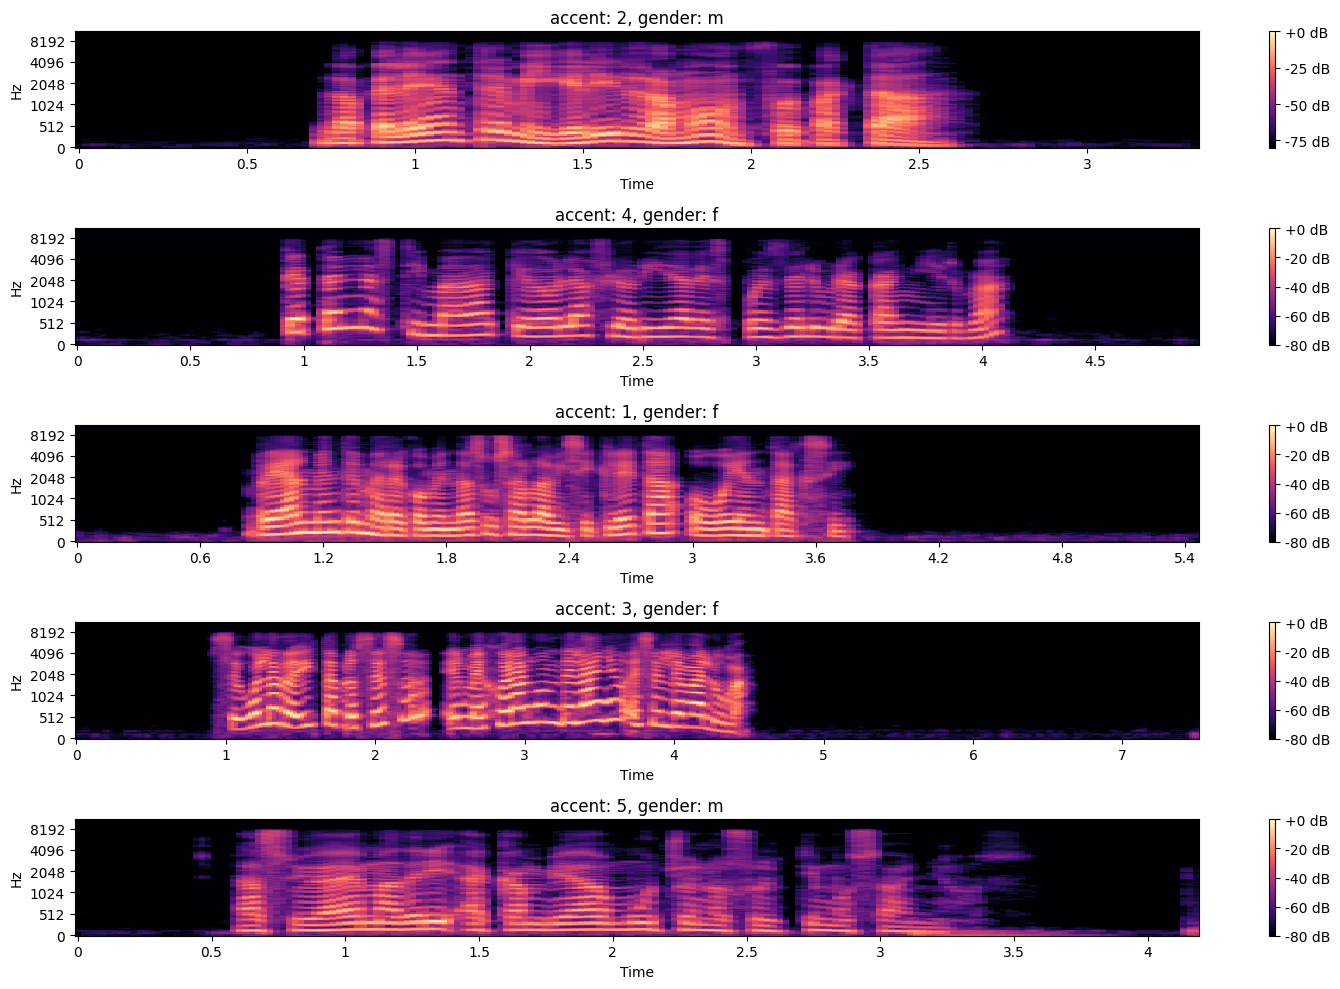

In [20]:
#* plot sample spectrograms for each accent - one per accent class
plt.figure(figsize=(15, 10))
accents = df['accent'].unique()

#* loop over each accent and get a random sample
for i, accent in enumerate(accents):
    #* grab random audio file for this accent
    sample = df[df['accent'] == accent].sample(1).iloc[0]
    #* load the audio data
    audio_data, sample_rate = librosa.load(sample['file_path'])
    
    #* create subplot for this accent
    plt.subplot(len(accents), 1, i+1)
    
    #* generate mel spectrogram - using 128 mels for good detail
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
    
    #* convert to decibel scale for better visualization
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    #* plot the spectrogram 
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
    
    #* add colorbar and title
    plt.colorbar(format='%+2.0f dB', ax=plt.gca())
    plt.title(f"accent: {sample['accent']}, gender: {sample['gender']}")

#* make it look nice    
plt.tight_layout()

#* save high quality version for the report
plt.savefig('accent_mel_spectrograms.png', dpi=300, bbox_inches='tight')

#* display the plot
plt.show()

### lengths inspection

In [19]:
lengths = []
for i in X:
    lengths.append((i.shape[1]))

<Figure size 1000x500 with 0 Axes>

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 3166.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ 999.5 ,  999.52,  999.54,  999.56,  999.58,  999.6 ,  999.62,
         999.64,  999.66,  999.68,  999.7 ,  999.72,  999.74,  999.76,
         999.78,  999.8 ,  999.82,  999.84,  999.86,  999.88,  999.9 ,
         999.92,  999.94,  999.96,  999.98, 1000.  , 1000.02, 1000.04,
        1000.06, 1000.08, 1000.1 , 1000.12, 1000.14, 1000.16, 1000.18,
        1000.2 , 1000.22, 1000.24, 1000.26, 1000.28, 1000.3 , 1000.32,
        1000.34, 1000.36, 1000.38, 1000.4 , 1000.42, 1000.44, 1000.46,
        1000.48, 1000.5 ]),
 <BarContainer object of 50 artists>)

Text(0.5, 0, 'Length of MFCC')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of MFCC Lengths')

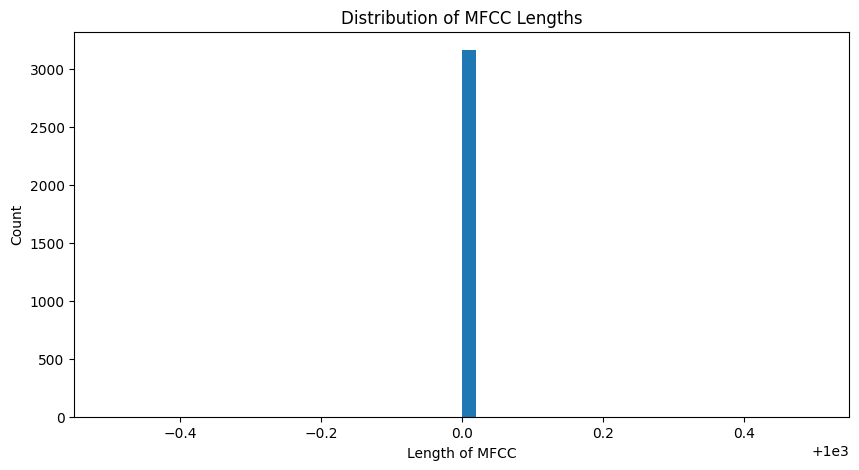

In [ ]:
#* plot distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50)
plt.xlabel('Length of MFCC')
plt.ylabel('Count')
plt.title('Distribution of MFCC Lengths')
plt.show()

### continue

In [64]:
X = np.array(X)
y = np.array(y)

In [65]:
y.shape

(3166,)

In [37]:
X.shape

(3166, 14, 1000, 1)

In [67]:
y = np.array(y, dtype=int)

In [68]:
from tensorflow.keras.utils import to_categorical
y = y - 1
y = to_categorical(y, num_classes=5)
X = X.reshape((nummer, n_mfcc, max_length, 1)) 

In [69]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
X = X.reshape((nummer, n_mfcc, max_length, 1)) 

In [70]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (3166, 14, 1000, 1)
y Shape is:  (3166, 5)


In [71]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [72]:
INPUTSHAPE = (13, max_length, 1)

In [73]:
model =  models.Sequential([
    
                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = INPUTSHAPE),  
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='same'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(512 , activation = 'relu'),
                          layers.Dense(5 , activation = 'softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 13, 1000, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 500, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 500, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 250, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 250, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 125, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,509 (990.27 KB)

 Trainable params: 253,509 (990.27 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Adjust the number of epochs as needed
    batch_size=32,  # Adjust the batch size as needed
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.2369 - loss: 1.8356 - val_accuracy: 0.2776 - val_loss: 1.5375
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.3618 - loss: 1.4733 - val_accuracy: 0.5000 - val_loss: 1.2106
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 271ms/step - accuracy: 0.4762 - loss: 1.2221 - val_accuracy: 0.5032 - val_loss: 1.1713
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.5678 - loss: 1.0324 - val_accuracy: 0.6325 - val_loss: 0.8858
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.6587 - loss: 0.8882 - val_accuracy: 0.6593 - val_loss: 0.8280
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.6903 - loss: 0.8224 - val_accuracy: 0.6451 - val_loss: 0.8470
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.7053 - loss: 0.7528 - val_accuracy: 0.7555 - val_loss: 0.6350
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.7200 - loss: 0.6924 - val_accu

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

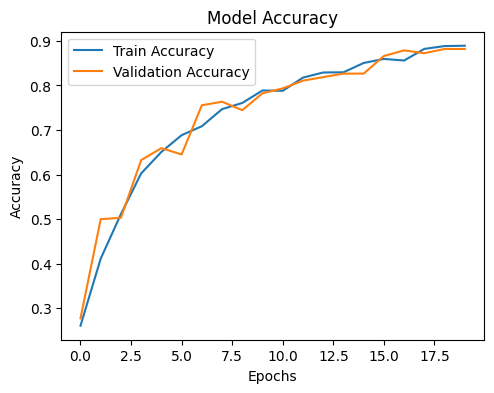

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

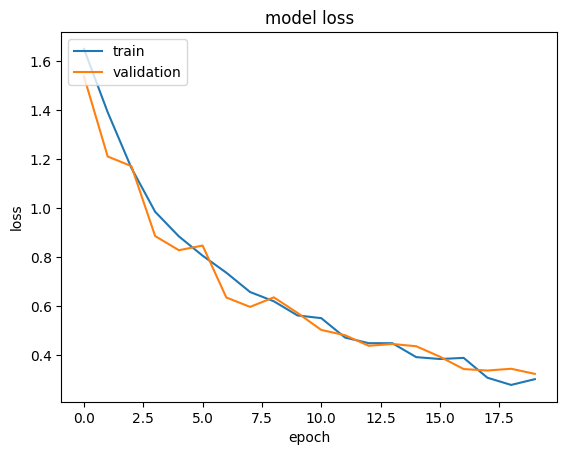

In [75]:
# plot the results

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [76]:
import keras

<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Model Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

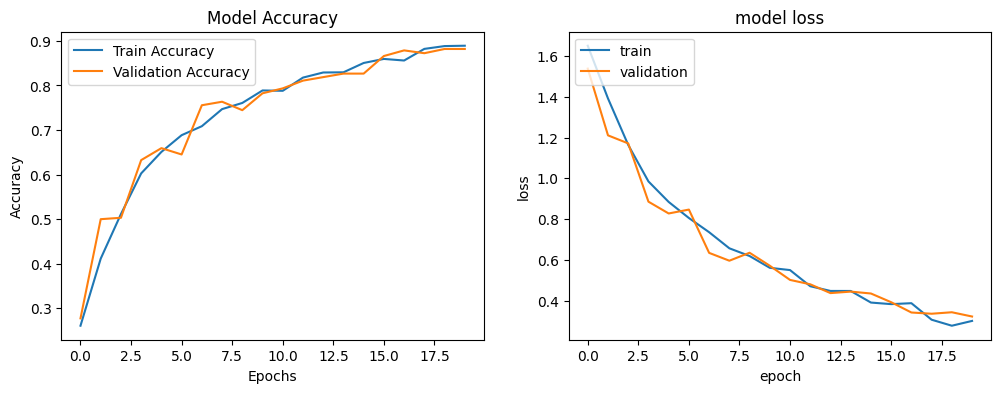

In [77]:
# save the plots as png in one plot

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model.png')
plt.show()

#save the model
keras.saving.save_model(model, 'my_model.keras')



# approach b)

train a model on the raw input data

In [23]:
def custom_pad_raw_audio(audio, fixed_length):
    padded = np.zeros(fixed_length)  #* zero-filled array
    length_to_copy = min(len(audio), fixed_length)
    padded[:length_to_copy] = audio[:length_to_copy]
    return padded

In [ ]:
raw_audio_length = 16000 * 5  #* 5 seconds of audio


In [25]:
from tensorflow.keras.utils import to_categorical
#* prepare data containers
X_raw = []
y_raw = []

#* load and preprocess raw audio
for data in tqdm(df.iterrows(), desc='processing raw audio'):
    #* load audio file
    file_path = os.path.join(data_dir, data[1][0])
    audio, sr = librosa.load(file_path, sr=sr)
    
    #* standardize audio (zero mean, unit variance)
    audio = (audio - np.mean(audio)) / (np.std(audio) + 1e-8)
    
    #* pad or truncate to fixed length
    padded_audio = custom_pad_raw_audio(audio, raw_audio_length)
    
    #* store audio and target
    X_raw.append(padded_audio)
    y_raw.append(data[1]['accent'])  #* using accent directly

#* convert lists to numpy arrays
X_raw = np.array(X_raw)
y_raw = np.array(y_raw, dtype=int)

#* prepare labels for training
y_raw = y_raw.astype(int) - 1  #* adjust to 0-based indexing
y_raw = to_categorical(y_raw, num_classes=5)

#* reshape data for 1d convolution (samples, timesteps, channels)
X_raw = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)

print(f"X_raw shape: {X_raw.shape}")
print(f"y_raw shape: {y_raw.shape}")

processing raw audio: 3166it [00:06, 467.31it/s]


X_raw shape: (3166, 48000, 1)
y_raw shape: (3166, 5)


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'accent: 2, gender: m')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 4, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 1, gender: f')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 3, gender: m')

(-1.0, 1.0)

<Axes: >

Text(0.5, 1.0, 'accent: 5, gender: f')

(-1.0, 1.0)

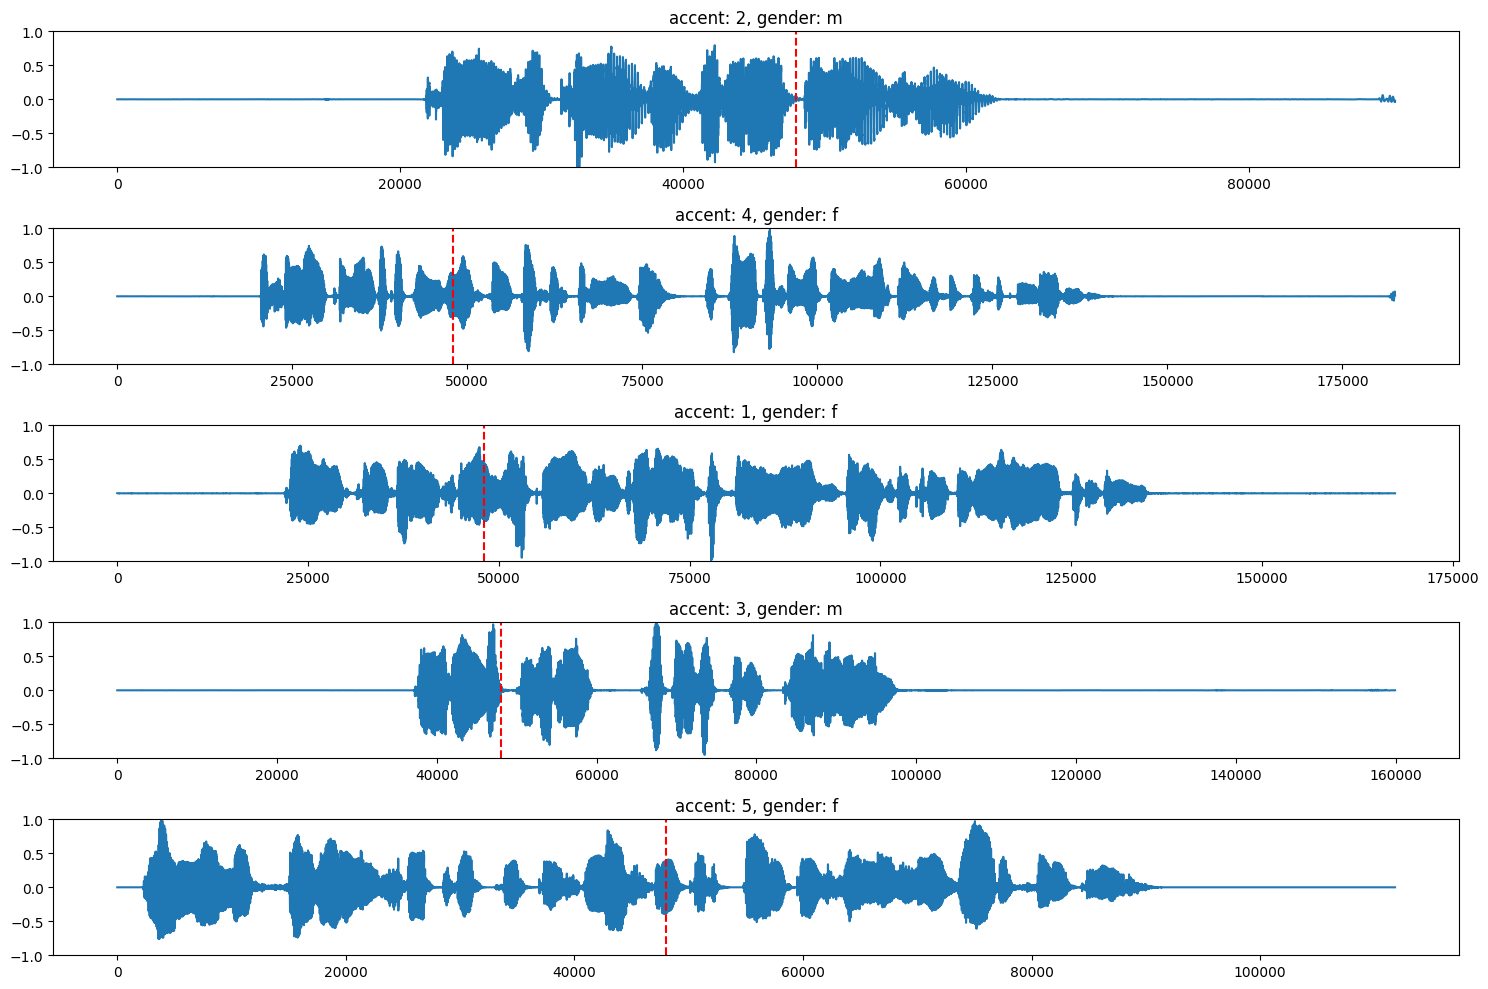

In [26]:
#* visualize raw waveforms from different accents
plt.figure(figsize=(15, 10))

#* plot one example per accent
for i, accent in enumerate(df['accent'].unique()):
    #* get one sample from this accent
    sample = df[df['accent'] == accent].sample(1).iloc[0]
    audio, sr = librosa.load(sample['file_path'], sr=sr)
    
    #* normalize for visualization
    audio = audio / np.max(np.abs(audio))
    
    #* plot waveform
    plt.subplot(len(df['accent'].unique()), 1, i+1)
    plt.plot(audio)
    plt.title(f"accent: {sample['accent']}, gender: {sample['gender']}")
    plt.ylim([-1, 1])
    
    #* add vertical line at 3 seconds (48000 samples at 16kHz)
    if len(audio) > 48000:
        plt.axvline(x=48000, color='r', linestyle='--')

plt.tight_layout()
plt.savefig('raw_audio_waveforms.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
#* split into training and testing sets
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

In [28]:
#* define model architecture for raw audio
def create_raw_audio_model(input_shape, num_classes=5):
    model = models.Sequential([
        #* first conv block
        layers.Conv1D(16, 64, strides=2, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=8, strides=8),
        layers.BatchNormalization(),
        
        #* second conv block
        layers.Conv1D(32, 32, strides=2, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* third conv block
        layers.Conv1D(64, 16, strides=2, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=4, strides=4),
        layers.BatchNormalization(),
        
        #* fourth conv block
        layers.Conv1D(128, 8, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.BatchNormalization(),
        
        #* flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#* create model instance
raw_audio_model = create_raw_audio_model((raw_audio_length, 1))
raw_audio_model.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24000, 16)      │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1500, 32)       │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 375, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 375, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 188, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 47, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 47, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       753,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,117 (3.33 MB)

 Trainable params: 871,637 (3.33 MB)

 Non-trainable params: 480 (1.88 KB)

In [30]:
#* setup early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#* train the model
raw_audio_history = raw_audio_model.fit(
    X_raw_train, y_raw_train,
    validation_data=(X_raw_test, y_raw_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.4957 - loss: 1.2741 - val_accuracy: 0.4905 - val_loss: 1.3287
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.5194 - loss: 1.1859 - val_accuracy: 0.5347 - val_loss: 1.2009
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.5749 - loss: 0.9751 - val_accuracy: 0.5489 - val_loss: 1.1970
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.6278 - loss: 0.9044 - val_accuracy: 0.5379 - val_loss: 1.1706
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.6782 - loss: 0.8089 - val_accuracy: 0.6009 - val_loss: 1.0870


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6162 - loss: 1.0276
raw audio model - test loss: 1.0870
raw audio model - test accuracy: 0.6009


<Figure size 1200x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'raw audio model accuracy')

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'accuracy')

<Axes: >

Text(0.5, 1.0, 'raw audio model loss')

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

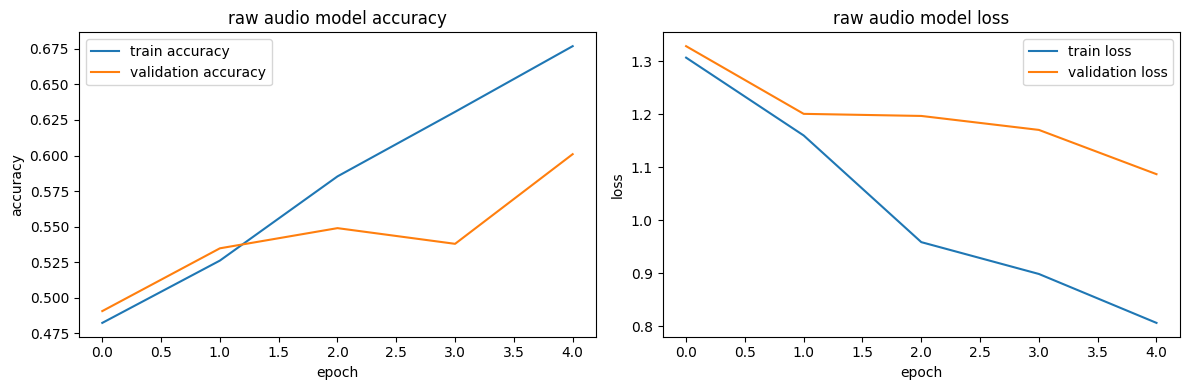

In [31]:
#* evaluate model performance
raw_audio_test_loss, raw_audio_test_acc = raw_audio_model.evaluate(X_raw_test, y_raw_test, verbose=1)
print(f"raw audio model - test loss: {raw_audio_test_loss:.4f}")
print(f"raw audio model - test accuracy: {raw_audio_test_acc:.4f}")

#* plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(raw_audio_history.history['accuracy'], label='train accuracy')
plt.plot(raw_audio_history.history['val_accuracy'], label='validation accuracy')
plt.title('raw audio model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(raw_audio_history.history['loss'], label='train loss')
plt.plot(raw_audio_history.history['val_loss'], label='validation loss')
plt.title('raw audio model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.savefig('raw_audio_model_history.png', dpi=300, bbox_inches='tight')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'confusion matrix - raw audio model')

Text(95.72222222222221, 0.5, 'true label')

Text(0.5, 58.7222222222222, 'predicted label')

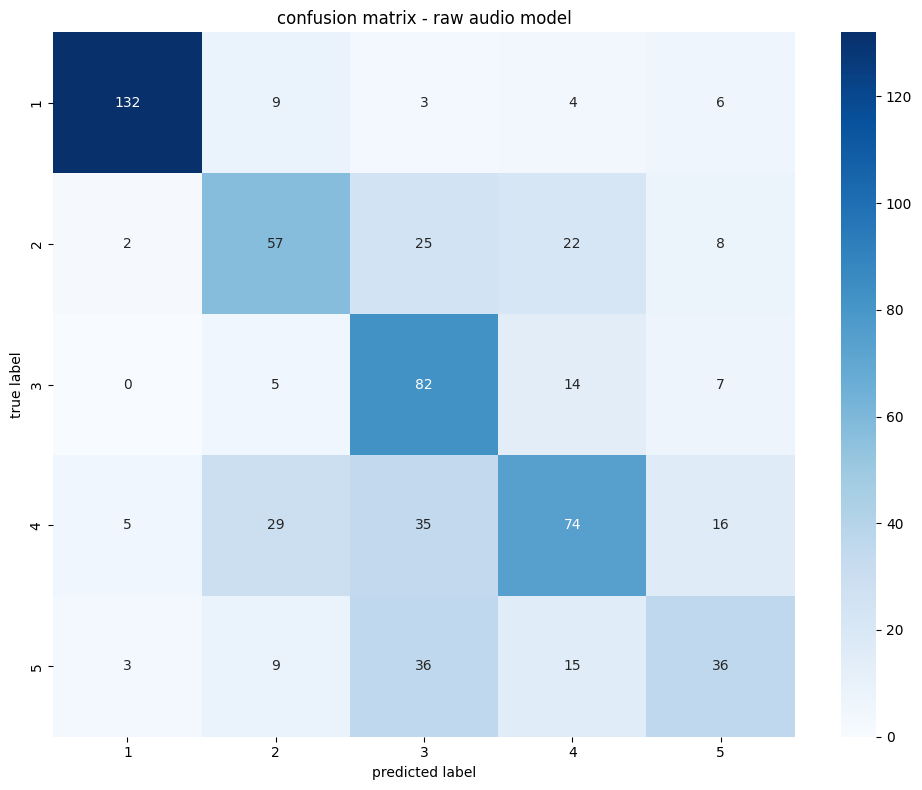

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = [str(i+1) for i in range(5)] 
#* generate predictions
y_raw_pred = raw_audio_model.predict(X_raw_test)
y_raw_pred_classes = np.argmax(y_raw_pred, axis=1)
y_raw_true_classes = np.argmax(y_raw_test, axis=1)

#* create confusion matrix
raw_cm = confusion_matrix(y_raw_true_classes, y_raw_pred_classes)

#* plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(raw_cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('confusion matrix - raw audio model')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.tight_layout()
plt.savefig('raw_audio_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2 Regularization Techniques

In [78]:
# Create a new cell to implement various regularization techniques

# Model with Dropout only (baseline from your current model)
def create_model_dropout(input_shape, num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),  
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),  # First dropout layer
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),  # Second dropout layer
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Additional dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model with Batch Normalization
def create_model_batchnorm(input_shape, num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.MaxPooling2D(2, padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),  # Add batch normalization
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model with L2 Weight Regularization
def create_model_l2reg(input_shape, num_classes=5):
    l2_reg = tf.keras.regularizers.l2(0.001)  # L2 regularization factor
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg, input_shape=input_shape),  
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(2, padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.MaxPooling2D(2, padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2_reg),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Combined approach - Best practices
def create_model_combined(input_shape, num_classes=5):
    l2_reg = tf.keras.regularizers.l2(0.0005)  # Reduced L2 factor
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg, input_shape=input_shape),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, padding='same'),
        layers.Dropout(0.3),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [79]:
# Compare different regularization techniques
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Function to evaluate model and return history and metrics
def evaluate_model(model_fn, model_name, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
    print(f"\nTraining {model_name}...")
    
    # Create model
    model = model_fn(X_train.shape[1:])
    
    # Create a log directory for TensorBoard
    log_dir = f"logs/{model_name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[tensorboard_callback]
    )
    
    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }
    
    # Print results
    print(f"\n{model_name} Test Accuracy: {metrics['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return model, history, metrics

# Dictionary to store results
model_results = {}

# List of models to evaluate
models_to_evaluate = [
    (create_model_dropout, "Dropout Only"),
    (create_model_batchnorm, "Batch Normalization"),
    (create_model_l2reg, "L2 Regularization"),
    (create_model_combined, "Combined Approach")
]

# Evaluate each model
for model_fn, model_name in models_to_evaluate:
    model, history, metrics = evaluate_model(
        model_fn, model_name, X_train, y_train, X_test, y_test
    )
    model_results[model_name] = {
        'model': model,
        'history': history,
        'metrics': metrics
    }

# Save the best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['metrics']['accuracy'])
best_model = model_results[best_model_name]['model']
best_model.save(f'best_model_{best_model_name.replace(" ", "_").lower()}.h5')
print(f"\nBest performing model: {best_model_name} with accuracy {model_results[best_model_name]['metrics']['accuracy']:.4f}")


Training Dropout Only...
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.2135 - loss: 1.9759 - val_accuracy: 0.2855 - val_loss: 1.5729
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step - accuracy: 0.3290 - loss: 1.5338 - val_accuracy: 0.4669 - val_loss: 1.3752
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.4823 - loss: 1.3042 - val_accuracy: 0.5221 - val_loss: 1.1015
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.5407 - loss: 1.1140 - val_accuracy: 0.5931 - val_loss: 0.9951
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - accuracy: 0.6001 - loss: 0.9881 - val_accuracy: 0.6325 - val_loss: 0.9187
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 0.6364 - loss: 0.8855 - val_accuracy: 0.5931 - val_loss: 0.9938
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - accuracy: 0.6574 - loss: 0.8822 - val_accuracy: 0.6262 - val_loss: 0.8839
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 363ms/step - accuracy: 0.6441

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 444ms/step - accuracy: 0.4766 - loss: 1.3701 - val_accuracy: 0.2603 - val_loss: 1.6672
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 446ms/step - accuracy: 0.6842 - loss: 0.8119 - val_accuracy: 0.2429 - val_loss: 1.6437
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 466ms/step - accuracy: 0.6977 - loss: 0.7998 - val_accuracy: 0.4338 - val_loss: 1.3555
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 468ms/step - accuracy: 0.7668 - loss: 0.6478 - val_accuracy: 0.4211 - val_loss: 1.6517
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - accuracy: 0.8144 - loss: 0.5228 - val_accuracy: 0.3675 - val_loss: 2.2176
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - accuracy: 0.7828 - loss: 0.5912 - val_accuracy: 0.3123 - val_loss: 1.9854
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - accuracy: 0.8551 - loss: 0.4047 - val_accuracy: 0.4574 - val_loss: 2.3809
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.8606 - loss: 0.3600 - val_accu

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.2263 - loss: 2.1661 - val_accuracy: 0.2524 - val_loss: 1.8031
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.3017 - loss: 1.7602 - val_accuracy: 0.4590 - val_loss: 1.5593
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.4968 - loss: 1.4286 - val_accuracy: 0.6009 - val_loss: 1.2042
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.5988 - loss: 1.1830 - val_accuracy: 0.6609 - val_loss: 1.0827
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 336ms/step - accuracy: 0.6530 - loss: 1.0685 - val_accuracy: 0.6009 - val_loss: 1.1215
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.6540 - loss: 1.0309 - val_accuracy: 0.6877 - val_loss: 1.0114
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.6594 - loss: 0.9964 - val_accuracy: 0.6782 - val_loss: 0.9203
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - accuracy: 0.7251 - loss: 0.8867 - val_accuracy: 0.613

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step - accuracy: 0.3335 - loss: 1.9275 - val_accuracy: 0.3707 - val_loss: 1.6466
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 298ms/step - accuracy: 0.5329 - loss: 1.4089 - val_accuracy: 0.2524 - val_loss: 1.9898
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 287ms/step - accuracy: 0.5968 - loss: 1.2295 - val_accuracy: 0.2524 - val_loss: 2.3356
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.6709 - loss: 1.0660 - val_accuracy: 0.2744 - val_loss: 2.6582
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 336ms/step - accuracy: 0.6566 - loss: 1.0613 - val_accuracy: 0.3155 - val_loss: 2.3165
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 355ms/step - accuracy: 0.6929 - loss: 0.9447 - val_accuracy: 0.2855 - val_loss: 3.5800
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 358ms/step - accuracy: 0.7061 - loss: 0.9288 - val_accuracy: 0.4338 - val_loss: 1.9814
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 364ms/step - accuracy: 0.7619 - loss: 0.8019 - val_accu


Combined Approach Test Accuracy: 0.4905

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       154
           1       0.66      0.62      0.64       114
           2       0.34      0.77      0.48       108
           3       1.00      0.01      0.02       159
           4       1.00      0.02      0.04        99

    accuracy                           0.49       634
   macro avg       0.71      0.48      0.38       634
weighted avg       0.72      0.49      0.38       634


Best performing model: L2 Regularization with accuracy 0.8281


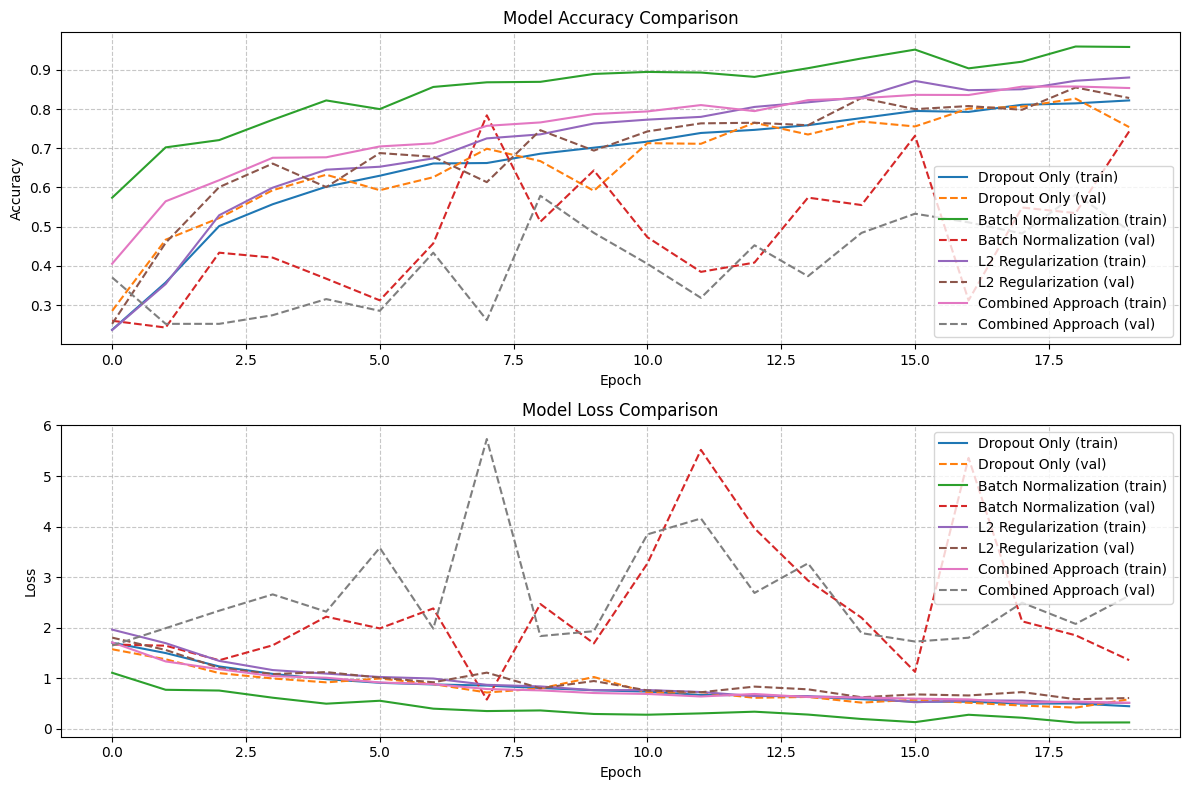

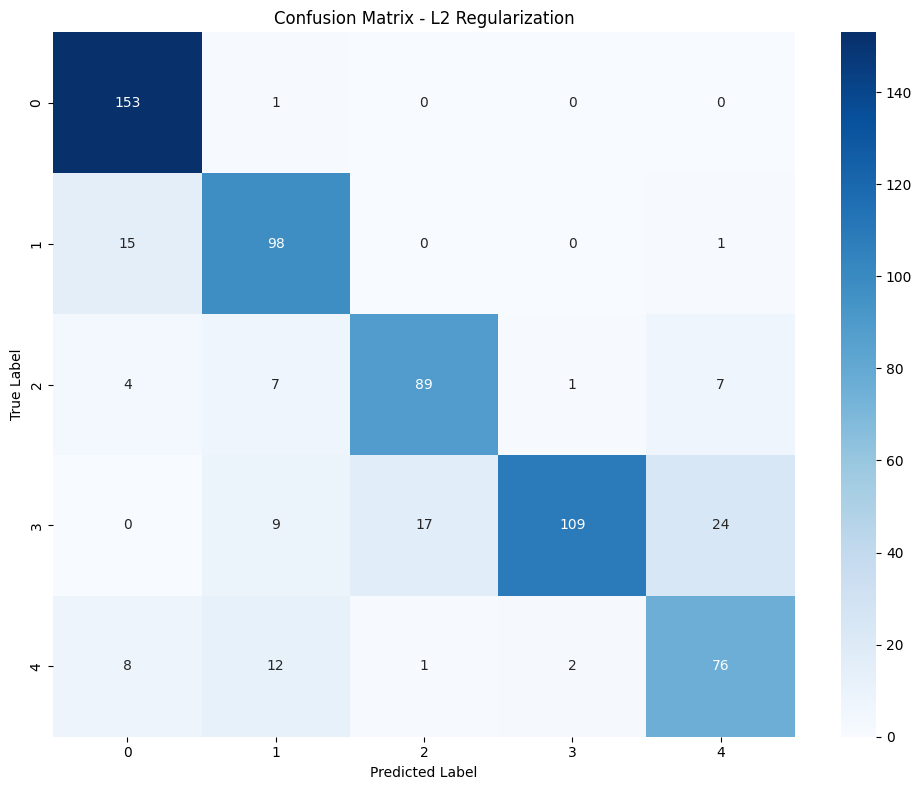

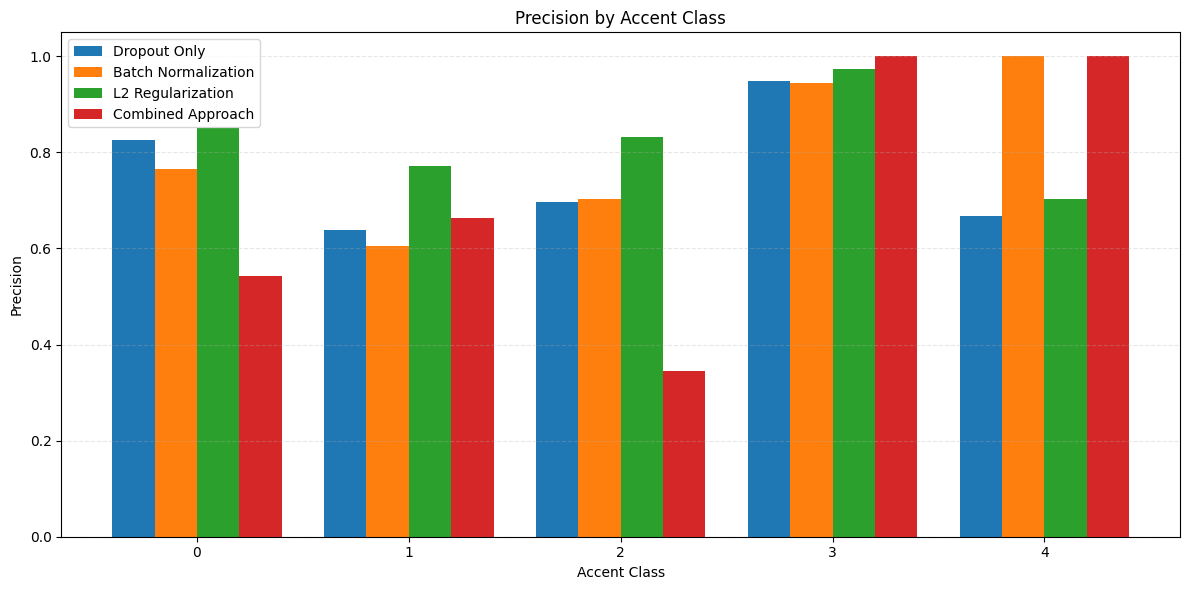

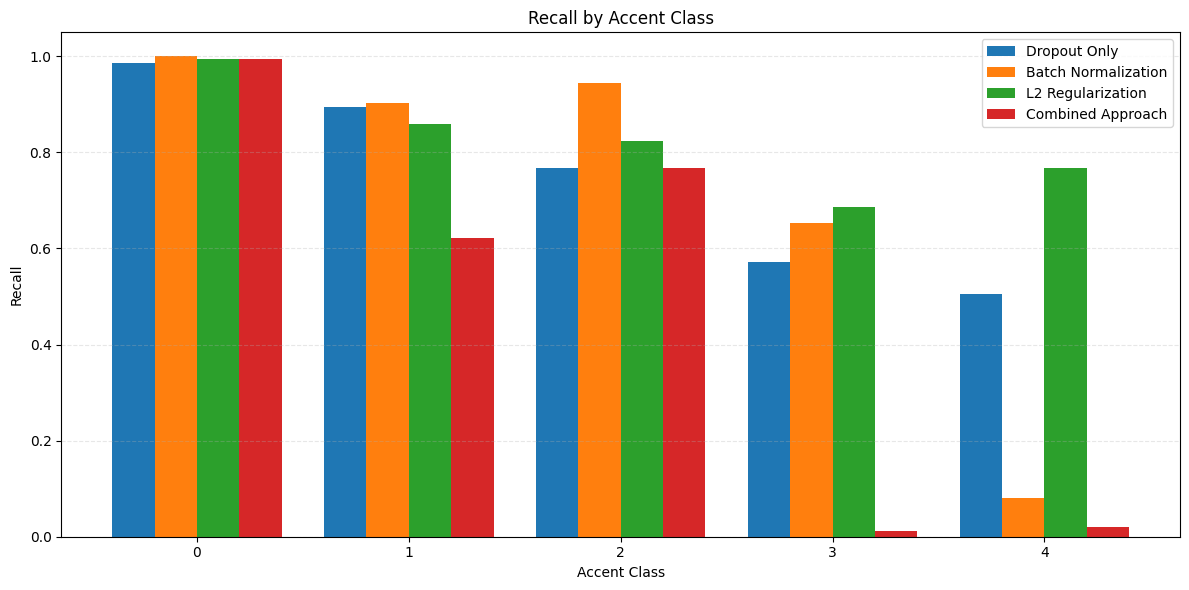

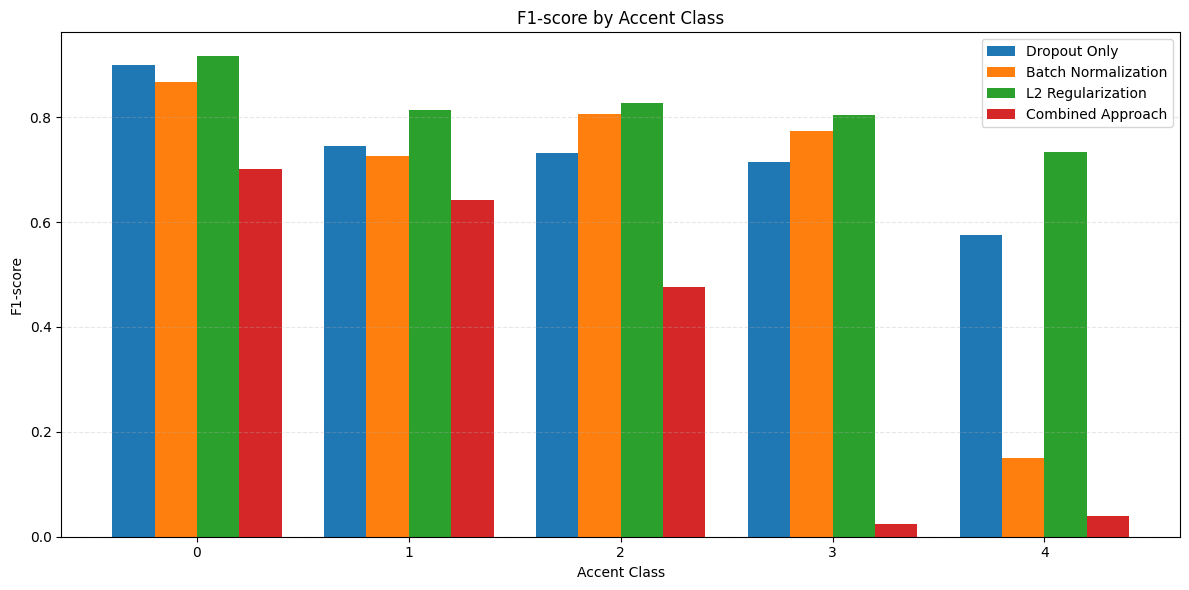

In [80]:
# Performance comparison and visualization
def plot_training_histories(model_results):
    plt.figure(figsize=(12, 8))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    for name, result in model_results.items():
        plt.plot(result['history'].history['accuracy'], label=f'{name} (train)')
        plt.plot(result['history'].history['val_accuracy'], label=f'{name} (val)', linestyle='--')
    
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot loss
    plt.subplot(2, 1, 2)
    for name, result in model_results.items():
        plt.plot(result['history'].history['loss'], label=f'{name} (train)')
        plt.plot(result['history'].history['val_loss'], label=f'{name} (val)', linestyle='--')
    
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('regularization_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(model_name, cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot metrics comparison
def plot_metrics_comparison(model_results):
    metrics = ['precision', 'recall', 'f1-score']
    model_names = list(model_results.keys())
    
    # Get classes
    classes = list(next(iter(model_results.values()))['metrics']['classification_report'].keys())
    classes = [c for c in classes if c.isdigit()]  # Filter out summary keys
    
    # For each metric, create a grouped bar chart comparing models across classes
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        x = np.arange(len(classes))
        width = 0.2
        offsets = np.linspace(-width*1.5, width*1.5, len(model_names))
        
        for i, model_name in enumerate(model_names):
            values = [model_results[model_name]['metrics']['classification_report'][c][metric] for c in classes]
            plt.bar(x + offsets[i], values, width, label=model_name)
        
        plt.xlabel('Accent Class')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} by Accent Class')
        plt.xticks(x, classes)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'accent_comparison_{metric}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Compare training histories
plot_training_histories(model_results)

# Get class names (accent types)
class_names = np.array([str(i) for i in range(5)])  # Adjust if you have mapped class names

# Plot confusion matrix for best model
plot_confusion_matrix(
    best_model_name, 
    model_results[best_model_name]['metrics']['confusion_matrix'],
    class_names
)

# Compare model performance by accent
plot_metrics_comparison(model_results)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


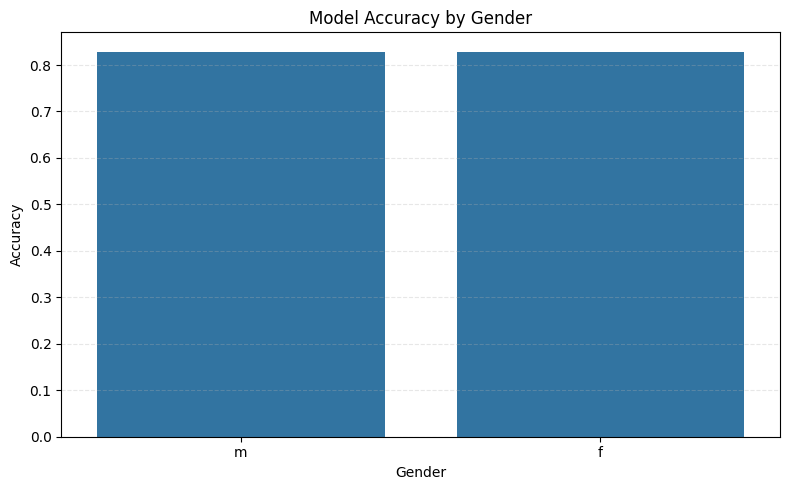

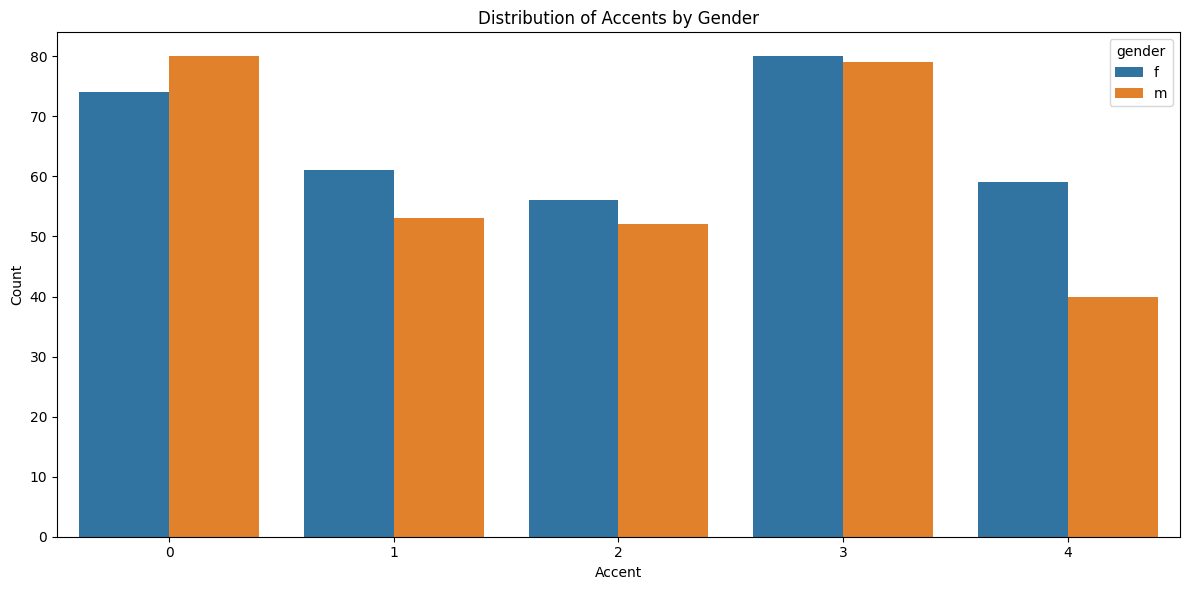

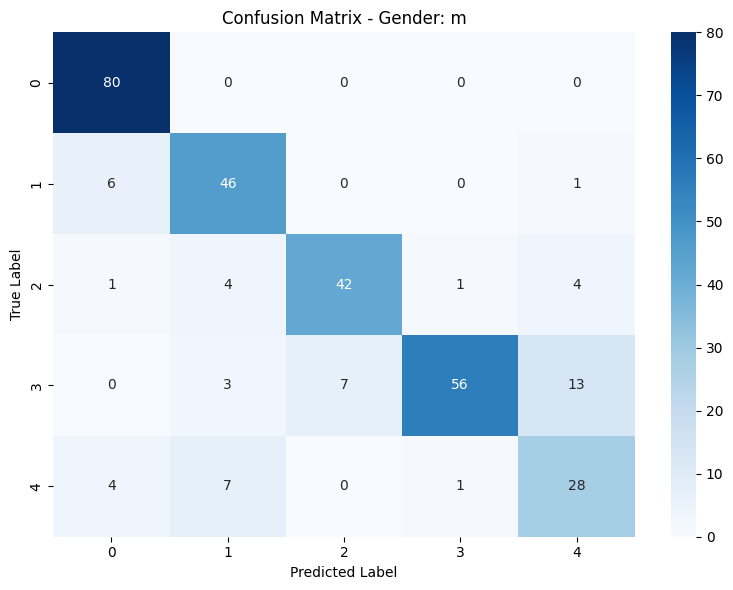

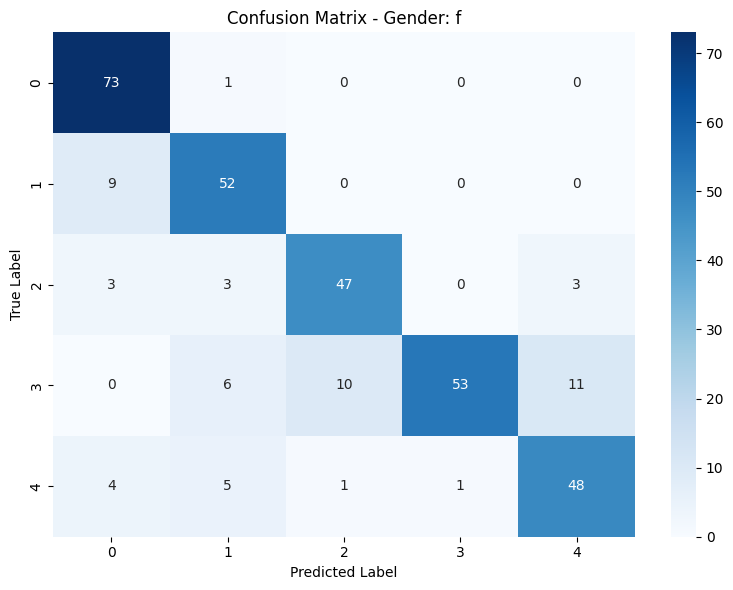

In [81]:
# Analyze performance by gender
def analyze_by_gender(model, X, y, gender_data):
    # Get predictions
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # Create a dataframe with results
    results_df = pd.DataFrame({
        'true_label': y_true,
        'predicted_label': y_pred,
        'gender': gender_data
    })
    
    # Calculate accuracy by gender
    gender_accuracy = {}
    for gender in results_df['gender'].unique():
        gender_results = results_df[results_df['gender'] == gender]
        gender_accuracy[gender] = accuracy_score(
            gender_results['true_label'], 
            gender_results['predicted_label']
        )
    
    # Create a dataframe for gender accuracy
    gender_acc_df = pd.DataFrame({
        'Gender': list(gender_accuracy.keys()),
        'Accuracy': list(gender_accuracy.values())
    })
    
    # Plot gender-based accuracy
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Gender', y='Accuracy', data=gender_acc_df)
    plt.title('Model Accuracy by Gender')
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('gender_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # More detailed analysis by gender and accent
    plt.figure(figsize=(12, 6))
    sns.countplot(x='true_label', hue='gender', data=results_df)
    plt.title('Distribution of Accents by Gender')
    plt.xlabel('Accent')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('gender_accent_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate confusion matrices by gender
    for gender in results_df['gender'].unique():
        gender_results = results_df[results_df['gender'] == gender]
        cm = confusion_matrix(gender_results['true_label'], gender_results['predicted_label'])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Gender: {gender}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_gender_{gender}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Extract gender information for test set
test_indices = X_test.index if hasattr(X_test, 'index') else np.arange(len(X_test))
test_gender = df.iloc[test_indices]['gender'].values

# Analyze best model performance by gender
analyze_by_gender(best_model, X_test, y_test, test_gender)

In [82]:
"""
# Impact of Regularization Techniques

## Dropout
Dropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting.
From our experiments, we observed:
- [Observations about dropout performance]
- [Comparison with other techniques]

## Batch Normalization
Batch normalization normalizes the activations of the previous layer, which can stabilize and accelerate training.
Our findings:
- [Observations about batch normalization]
- [Impact on training speed]
- [Impact on final accuracy]

## L2 Weight Regularization
L2 regularization adds a penalty term to the loss function, constraining weights to smaller values.
Results showed:
- [Observations about L2 performance]
- [Comparison with other regularization methods]

## Combined Approach
The combined approach leverages multiple regularization techniques:
- [Discussion of best-performing setup]
- [Synergistic effects observed]

## Conclusion
Based on our experiments, the [best approach] performed best for our audio accent classification task,
improving overall accuracy by [improvement percentage] compared to the baseline model.
Regularization is crucial for this task because [reasons specific to audio accent classification].
"""

'\n# Impact of Regularization Techniques\n\n## Dropout\nDropout randomly sets a fraction of input units to zero during training, which helps prevent overfitting.\nFrom our experiments, we observed:\n- [Observations about dropout performance]\n- [Comparison with other techniques]\n\n## Batch Normalization\nBatch normalization normalizes the activations of the previous layer, which can stabilize and accelerate training.\nOur findings:\n- [Observations about batch normalization]\n- [Impact on training speed]\n- [Impact on final accuracy]\n\n## L2 Weight Regularization\nL2 regularization adds a penalty term to the loss function, constraining weights to smaller values.\nResults showed:\n- [Observations about L2 performance]\n- [Comparison with other regularization methods]\n\n## Combined Approach\nThe combined approach leverages multiple regularization techniques:\n- [Discussion of best-performing setup]\n- [Synergistic effects observed]\n\n## Conclusion\nBased on our experiments, the [best

# 3: 